In [126]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np

In [127]:
def generate_exchange_matrix(size: int, graph) -> list:
    """ノード間の通信コストを表す交流行列を作成

    Args:
        size (int): 行列のサイズ size x size
        graph: ネットワークトポロジ- (networkxのグラフ)
    Returns:
        list: n x nの正方行列
    """
    
    # graphの隣接リストを取得
    adj_list = nx.to_dict_of_lists(graph)
    # 通信コストの行列を作成
    matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            # 自身との通信は0
            if i == j:
                matrix[i][j] = 0
            # 隣接している場合は1~100の乱数(通信コストを与える)
            # (j+1)が隣接リストの(i+1)番目の要素(配列)に含まれているかどうかで判定
            elif j + 1 in adj_list[i + 1]:
                matrix[i][j] = random.randint(1, 100)
            # 隣接していない場合は-1(通信できないので)
            else:
                matrix[i][j] = -1

    # 対称性を持たせる
    for i in range(size):
        for j in range(size):
            if i < j:
                matrix[i][j] = matrix[j][i]
                

    for i in range(size):
        for j in range(size):
            if j+1 in adj_list[i+1]:
                graph.add_edge(i+1, j+1, weight=matrix[i][j])
    
    return matrix

In [128]:
def generate_random_circular_graph(num_nodes: int)-> nx.Graph:
    """ネットワークトポロジーを表すグラフを作成

    Args:
        num_nodes (int): ノードの数

    Returns:
        nx.Graph: トポロジーを表すグラフ
    """
    
    G = nx.Graph()  # Create an empty graph

    # Add nodes to the graph
    G.add_nodes_from(range(1, num_nodes+1))
    
    # Connect edges randomly for circular structure
    for i in range(1, num_nodes+1):
        G.add_edge(i, i % num_nodes + 1)

    # Connect additional random inside edges
    for i in range(1, num_nodes+1):
        for j in range(i+1, num_nodes+1):
            if random.random() < 0.5:  # Probability of connecting two nodes
                G.add_edge(i, j)

    return G

In [129]:
def weightintg_graph(graph: nx.graph, exchange_matrix: list):
    """グラフに重み付け(通信コスト)を与える

    Args:
        graph (nx.graph): 重み付きグラフ(トポロジー)
        exchange_matrix (list): 通信コストを表す交流行列
    """
    
    num_nodes = len(exchange_matrix)
    adj_list = nx.to_dict_of_lists(graph)
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            if j+1 in adj_list[i+1]:
                graph.add_edge(i+1, j+1, weight=exchange_matrix[i][j])

交流行列[[ 0. 19. -1.  9.]
 [19.  0. 84. -1.]
 [-1. 84.  0. 91.]
 [ 9. -1. 91.  0.]]


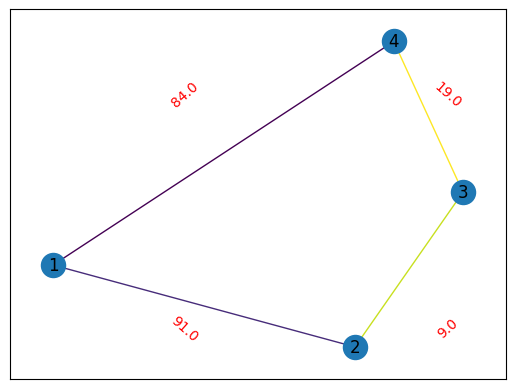

In [130]:
# ネットワークトポロジーを作成
G = generate_random_circular_graph(4)

# 交流行列を作成
exchange_matrix = generate_exchange_matrix(4, G)

# グラフのエッジに通信コスト(交流行列より)を付与
weightintg_graph(G, exchange_matrix)

# グラフの描画
pos = nx.circular_layout(G)
weights = nx.get_edge_attributes(G, 'weight').values()
nx.draw_networkx(G, edge_color = weights)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

print(f'交流行列{exchange_matrix}')